## Importing, time stepping, and grid spacing

[49232.17882584 49232.17882584 47936.59517252 46641.0115192
 45345.42786589 44049.84421257 42754.26055926 41458.67690594
 40163.09325263 38867.50959932 37571.925946   36276.34229269
 34980.75863938 33685.17498607 32389.59133276 31094.00767945
 29798.42402614 28502.84037282 27207.25671951 25911.6730662
 24616.08941289 23320.50575958 22024.92210627 20729.33845296
 19433.75479965 18138.17114634 16842.58749303 15547.00383972
 14251.42018641 12955.8365331  11660.25287979 10364.66922648
  9069.08557317  7773.50191986  6477.91826655  5182.33461324
  3886.75095993  2591.16730662  1295.58365331     0.        ]
[-1.23377717e-04 -1.23377717e-04  1.17944575e-04 -1.23844474e-04
  1.16953378e-04 -1.24337035e-04  1.15633346e-04 -1.24998031e-04
  1.13844408e-04 -1.25901516e-04  1.11371648e-04 -1.27162450e-04
  1.07875900e-04 -1.28964659e-04  1.02804393e-04 -1.31612246e-04
  9.52221273e-05 -1.35628453e-04  8.34774757e-05 -1.41955975e-04
  6.44992812e-05 -1.52388563e-04  3.22130640e-05 -1.70571977e-04
 

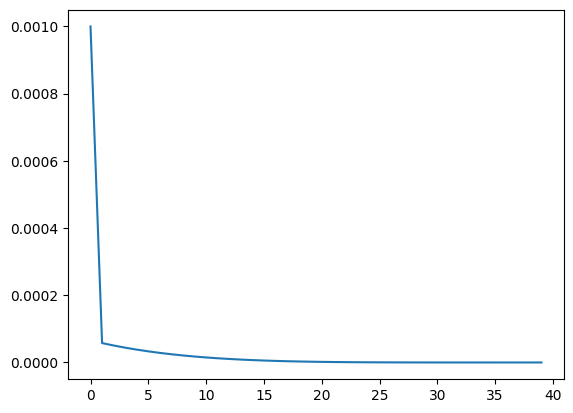

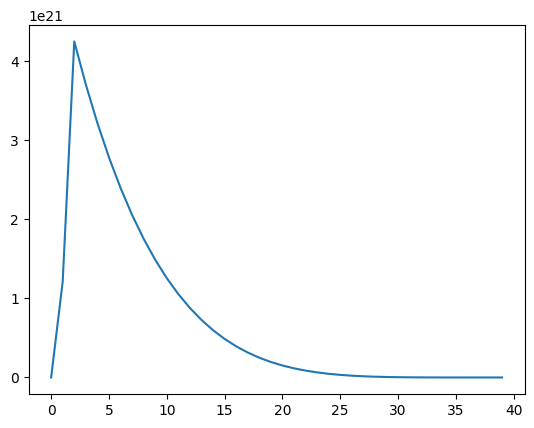

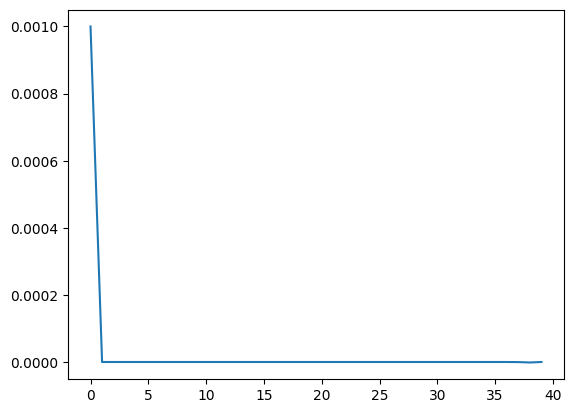

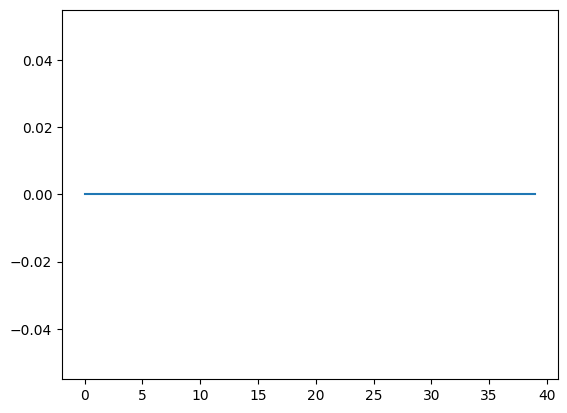

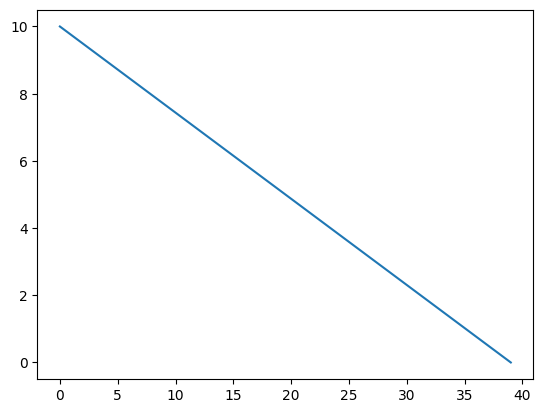

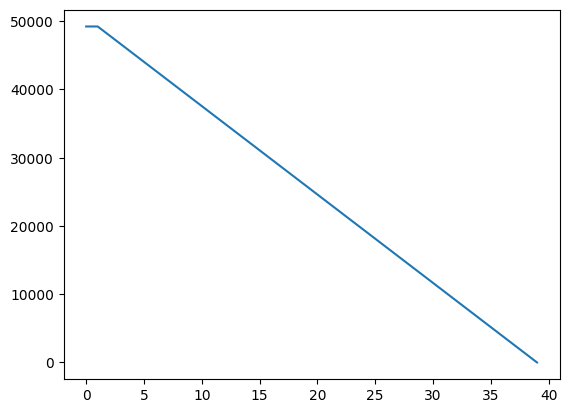

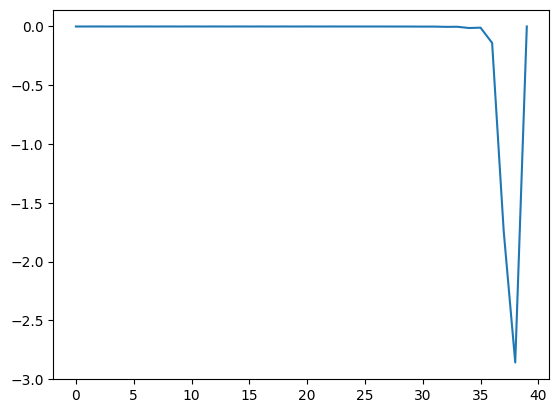

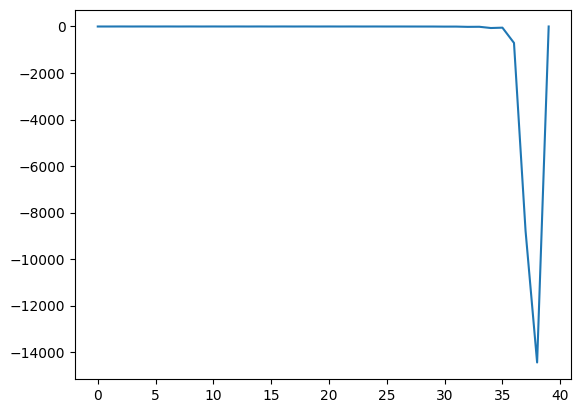

In [149]:
import numpy as np
#import climlab # package used for calculating orbital parameters overtime
#from climlab.solar.orbital import OrbitalTable
#from climlab.solar.insolation import daily_insolation
import matplotlib.pyplot as plt
from scipy.sparse import diags


#timesteping 
t_i = 0
t_f = -5000 #run model for the past 700,000 years 
d_t = 0.5  #use time step of 100 years
t = np.arange(t_f, t_i+1, d_t)
t_kyr = (t/(1000)) # years in kyr, needed to calculate orbital parameters

#grid spacing
x_i = 0 # corresponds to 74 degrees N latitute (northern boundary) 
x_f = 400000 # corresponds to 60 degrees N latitude (southern boundary)
d_x = 10000
x = np.arange(x_i, x_f, d_x)



# Parameters
A = 5.77e-4 #meters^-3 years^-1
alpha = 5
beta = 2

# Initialize glacier 
#want to the northern part of glacier to be 920 m and decrease moving south so the southern border is 0 m
h_ini = np.linspace(10, 0, len(x))



def D(H_vec):
    Diff = np.zeros(len(H_vec))
    for i in range(1, len(H_vec) - 1):
        Diff[i] = abs(H_vec[i + 1] - H_vec[i - 1])**beta * (H_vec[i]**alpha) / (2 * d_x)**beta
    Diff[0] = 1e-3  # Small value at boundaries
    return Diff


def Alpha(D_vec):
    Alpha_diag = np.zeros((len(D_vec))-1)
    for i in range(1, len(D_vec)-1):
        Alpha_diag[i-1] = d_t/(4*d_x**2) * ( -D_vec[i+1] + D_vec[i-1] + 4 * D_vec[i]) * A * 0.7**(beta+1)
    Alpha_diag[-1] = 0
    return Alpha_diag

def Beta(D_vec):
    Beta_diag = np.zeros(len(D_vec))
    for i in range(1, len(D_vec)-1):
        Beta_diag[i] = d_t * ( (-2 * D_vec[i]) / (d_x**2) + (1/d_t)) * A * 0.7**(beta+1)
    Beta_diag[0] = 1
    Beta_diag[-1] = 1
    return Beta_diag

def Gamma(D_vec):
    Gamma_diag = np.zeros(len(D_vec)-1)
    for i in range(1, len(D_vec)-1):
        Gamma_diag[i] = (d_t)/(4*d_x**2) * ( D_vec[i+1] - D_vec[i-1] + 4 * D_vec[i]) * A * 0.7**(beta+1)
        
    Gamma_diag[0] = 1
    return Gamma_diag


sols = np.zeros((len(x), len(t)))
D_ini = D(h_ini)
diffs = np.zeros((len(D_ini), len(t)))
sols[:, 0] = h_ini
diffs[:, 0] = D_ini
h = h_ini

for i in range(3):
    
    #Solve for diffusivity value at each grid point
    Diffusivity = D(h)
    diffs[:, i] = Diffusivity

    #calculate entries in P matrix
    lower_diag = -1*Alpha(Diffusivity)
    center_diag = Beta(Diffusivity)
    upper_diag = -1*Gamma(Diffusivity)

    #Build M matrix to solve
    diagonals = [lower_diag, center_diag, upper_diag]
    M = diags(diagonals, [-1, 0, 1]).toarray()

    h[0] = 0
    h[-1] = 0

    h_new = np.linalg.solve(M, h)
    print(h_new)
    
    h = h_new
    #update solutions
    sols[:, i+1] = h



plt.figure()
plt.plot(diffs[:, 0])
plt.figure()
plt.plot(diffs[:, 1])
plt.figure()
plt.plot(diffs[:, 2])
plt.figure()
plt.plot(diffs[:, 3])

plt.figure()
plt.plot(sols[:, 0])
plt.figure()
plt.plot(sols[:, 1])
plt.figure()
plt.plot(sols[:, 2])
plt.figure()
plt.plot(sols[:, 3])





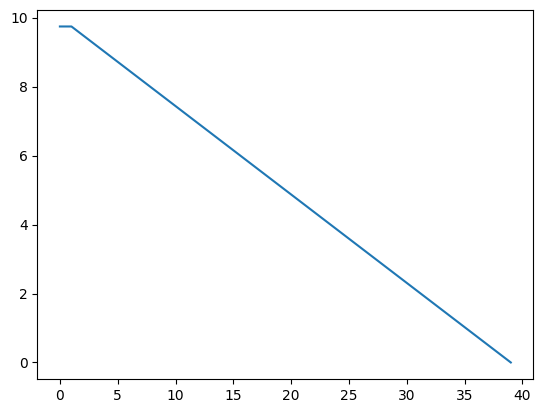

In [144]:
plt.figure()
plt.plot(sols[:, -1])